***Dio Navialdy 1301204001***

Paper: https://arxiv.org/pdf/2310.16742v1.pdf

Code: https://github.com/ArunSehrawat/Interferometric-Neural-Networks/tree/main

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time, copy

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score


# setting random seeds for reproducibility of results
torch.manual_seed(0)
np.random.seed(0)

c:\ProgramData\Miniconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\ProgramData\Miniconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Load Dataset

In [2]:
img_HW = 28           
d = img_HW**2   

print(f'image Hight = image Width = {img_HW}')
print(f'img_HW**2 = dimension of the Hilbert space = d = {d} \n')

#================================================================================================

transform = transforms.Compose([ 
    transforms.Resize((img_HW, img_HW)),                          # resize image 
    transforms.ToTensor(),                                        # to transform an image into a tensor
    transforms.Normalize(mean=(0.5,), std=(0.5,))                 # to put all the values between -1 and 1
])

##Dataset CIFAR10
train_dataset = datasets.EMNIST(root='',split='letters', 
                                       train=True, download=True, transform=transform)
test_dataset = datasets.EMNIST(root='',split='letters',  
                                      train=False, download=True, transform=transform)
#================================================================================================

print(f'number of (train, test) examples = {len(train_dataset), len(test_dataset)}')

print(f'number of classes = {27}')

classes = list(range(27))

image Hight = image Width = 28
img_HW**2 = dimension of the Hilbert space = d = 784 

number of (train, test) examples = (124800, 20800)
number of classes = 27


x of torch.Size([1, 28, 28]) :


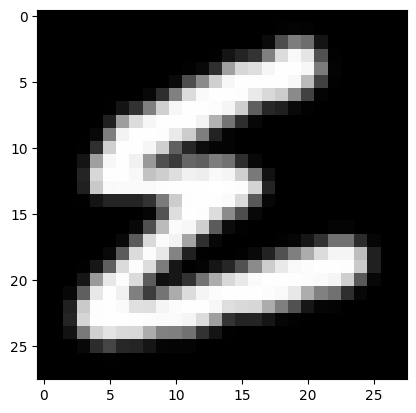

true label = y = 13

(x_min, x_max) = (-1.0, 1)


In [3]:
idx = np.random.choice(len(train_dataset))

x = train_dataset[idx][0]
print(f'x of {x.shape} :')

plt.imshow(x[0], cmap='gray')
plt.show()

print(f'true label = y = {train_dataset[idx][1]}\n')

print(f'(x_min, x_max) = {x.min().item(), round(x.max().item(),)}')

Define Quantum Machine Learning (QML) model : Interferometric Neural Network (INN)

In [4]:
class parallel_interferometers(nn.Module):
    def __init__(self, dim_out, dim_in):
        super(parallel_interferometers, self).__init__()
        
        self.dim_out = dim_out                                            # output dimention 
        self.dim_in = dim_in                                              # input dimention 
                                          
        torch.manual_seed(1)                         # setting a specific seed for reproducibility of results
        phases = torch.randn((1, dim_out, dim_in), dtype=torch.float)     # Initialize learnable phases 
        nn.init.xavier_uniform_(phases)     
        self.phases = nn.Parameter(phases) 
        
        
    def forward(self, x):                          # x.shape = (batch_size, 1 or dim_out, dim_in) 
        x = x * torch.exp(1j * self.phases)        # Perform dim_out parallel phase shifters
        x = torch.fft.fft(x, norm='ortho')         # Perform parallel 1D Fast Fourier Transforms (beamsplitters)
        return x                                   # x.shape = (batch_size, dim_out, dim_in)

In [5]:
class interferometric_block(nn.Module):                                      
    def __init__(self, dim_out, dim_in, L, channels=1):                 
        super(interferometric_block, self).__init__()
        
        self.dim_out = dim_out                                            # output dimention 
        self.dim_in = dim_in                                              # input dimention 
        self.L = L                                                        # number of quantum layers
        self.channels = channels
        
        self.phase_filters_layers = nn.ModuleList([parallel_interferometers(dim_out, dim_in) for _ in range(L)])
        
        
    def forward(self, x):
        x = x.view(-1, self.channels, self.dim_in)
        
        x = F.normalize(x, dim=-1)           # amplitude encodings  x -->  |x>
        
        #------------------------------------------------------------------------------------ 
        
        x = torch.fft.fft(x, norm='ortho')   # First ID Fast Fourier Transforms (beamsplitters)
        
        for phase_filters in self.phase_filters_layers:
            x = phase_filters(x)
            
         #------------------------------------------------------------------------------------
            
        x = x*(x.conj())                     # measurement in the computational basis and getting probabilities 
        x = torch.real(x)                    # dropping the imaginary components 0j

        x = x[:,:,0]                         # probability of getting 0 outcome from each sequence
    
        return x 
    

In [6]:
class INN(nn.Module):                               # Define QML model = Interferometric Neural Network (INN)
    def __init__(self, dims, Ls):                                
        super(INN, self).__init__()
        
        self.dims = dims                            # dimension of a feature vector before or after a block
        self.Ls = Ls                                # number of quantum layers in a block
        self.M = len(dims) - 1                      # number of blocks = M
        
        
        self.blocks = nn.ModuleList()               # Initialize an empty ModuleList
        
        for i in range(self.M-1):
            self.blocks.append(interferometric_block(dim_out=dims[i+1], dim_in=dims[i], L=Ls[i]))
        
        self.last_block = interferometric_block(dim_out=dims[-1], dim_in=dims[-2], L=Ls[-1])
        
        
    def forward(self, x):  
        
        for block in self.blocks:
            x = block(x)
            
        x = self.last_block(x)
        
        return x 

Hyperparameter

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device = {device}')
torch.set_num_threads(8)                                             # it is for reproducibility of results

#==================================================================

print(f'image Hight = image Width = {img_HW}')
print(f'dimension of the Hilbert space = d = {d}\n')



dims = [d, 2**5, 27]
Ls = [2,2]                                           # set Ls = [2,2] or Ls = [1, 1] to get our reported Results
print(f'dimension of a feature vector after a block = {dims}')
print(f'number of quantum layers in a block = {Ls}')

num_phases = int(np.sum(np.array(dims[:-1]) * Ls * dims[1:]))
print(f'number of learnable (parameters) phases in the model = {num_phases}\n')

#---------------------------------------------------------------
# optimizer Adam's hyperparameters

lr = 1e-2

b1 = 0.5
b2 = 0.9

#==================================================================

batch_size = 2**5
epochs = 3

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
num_batches = len(train_dataloader)
print(f'number of batches = {num_batches}, batch_size = {batch_size}\n')

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

device = cpu
image Hight = image Width = 28
dimension of the Hilbert space = d = 784

dimension of a feature vector after a block = [784, 32, 27]
number of quantum layers in a block = [2, 2]
number of learnable (parameters) phases in the model = 51904

number of batches = 3900, batch_size = 32



Training

In [8]:
%%time

                        
model = INN(dims=dims, Ls=Ls).to(device)                                   # start the QML model instance
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(b1, b2))    # define optimizer for the model
loss_fn = nn.CrossEntropyLoss()                                            # define loss functions for the model



#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Train_Loss = []
for t in range(epochs):
    print()
    print(f"Epoch {t:2d} ---------------------------------- \n")
    for batch_idx, (X, y) in enumerate(train_dataloader):

        X, y = X.to(device), y.to(device) 
        
        out = model(X)                            # Perform a single forward pass through the model
        loss = loss_fn(out, y)
   
        model.zero_grad()                         # Clear gradients 
        loss.backward(retain_graph=True)          # Derive gradients, backpropagation 
        optimizer.step()                          # Update parameters of the model based on gradients

        #-------------------------------------------------------------------------------
        
        if batch_idx % 200 == 0: 
            print(f'after {batch_idx:4d} batch      train loss: {loss:.4f}') 
            Train_Loss.append(loss.detach().item())
            
                                      
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        
print(f'\n ~~~~~ training is done ~~~~~\n ')


Epoch  0 ---------------------------------- 

after    0 batch      train loss: 3.2959
after  200 batch      train loss: 3.0678
after  400 batch      train loss: 2.9588
after  600 batch      train loss: 2.8243
after  800 batch      train loss: 2.9802
after 1000 batch      train loss: 2.8063
after 1200 batch      train loss: 2.8044
after 1400 batch      train loss: 2.8071
after 1600 batch      train loss: 2.8249
after 1800 batch      train loss: 2.6933
after 2000 batch      train loss: 2.6631
after 2200 batch      train loss: 2.7346
after 2400 batch      train loss: 2.8099
after 2600 batch      train loss: 2.7714
after 2800 batch      train loss: 2.7086
after 3000 batch      train loss: 2.7397
after 3200 batch      train loss: 2.7936
after 3400 batch      train loss: 2.6764
after 3600 batch      train loss: 2.6736
after 3800 batch      train loss: 2.6958

Epoch  1 ---------------------------------- 

after    0 batch      train loss: 2.7547
after  200 batch      train loss: 2.7169
afte

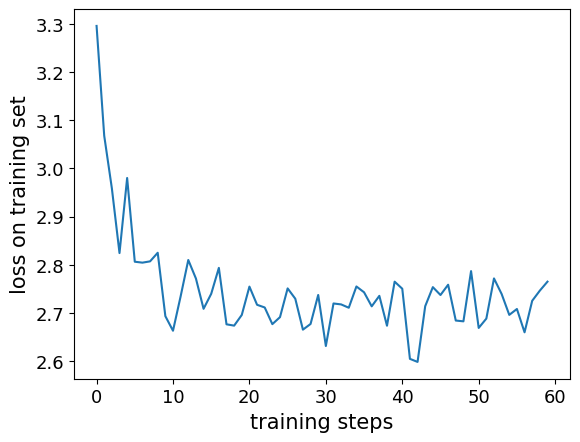

In [9]:
plt.plot(Train_Loss, label='train set')
plt.ylabel('loss on training set',fontsize=15)
plt.xlabel('training steps',fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.show()

Performance Test

In [12]:
def probabilities(dataloader, model):
    model.eval()
    with torch.no_grad():
        ys, probs = torch.tensor([]), torch.tensor([]) 
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            ys = torch.cat((ys, y), 0)
            
            prob = model(X)
            probs = torch.cat((probs, prob), 0)
    return ys, probs



def performance_estimate(y, prob, dataset_name):
    '''With a model, this function computes loss and other metrics on the training or test set'''
    y = y.to(torch.int64)
    loss = loss_fn(prob, y).item()
    
    prob = F.softmax(prob, dim=-1)                              # to make individual probabilities add to one
    #au_roc = roc_auc_score(y, prob, multi_class='ovr')
    
            
    y_pred = prob.argmax(1)
    f1 = f1_score(y, y_pred, average='macro')
            
    print(classification_report(y, y_pred))
    print(confusion_matrix(y, y_pred), f"= confusion matrix on {dataset_name} set")
    
    print(f"average f1_score on {dataset_name} set = {f1:.2f}")
    print(f"loss on {dataset_name} set = {loss:.3f}")
    #print(f"roc_auc_score on {dataset_name} set = {au_roc:.2f} \n")
    
    return

#==================================================================================================


y_train, prob_train = probabilities(train_dataloader, model)
performance_estimate(y_train, prob_train, 'train')

y_test, prob_test = probabilities(test_dataloader, model)
performance_estimate(y_test, prob_test, 'test')

              precision    recall  f1-score   support

           1       0.60      0.57      0.58      4800
           2       0.76      0.76      0.76      4800
           3       0.74      0.73      0.73      4800
           4       0.55      0.72      0.63      4800
           5       0.64      0.76      0.70      4800
           6       0.68      0.74      0.71      4800
           7       0.52      0.53      0.53      4800
           8       0.79      0.68      0.73      4800
           9       0.47      0.49      0.48      4800
          10       0.73      0.62      0.67      4800
          11       0.67      0.75      0.71      4800
          12       0.48      0.42      0.45      4800
          13       0.87      0.87      0.87      4800
          14       0.56      0.71      0.63      4800
          15       0.77      0.88      0.82      4800
          16       0.81      0.78      0.79      4800
          17       0.62      0.50      0.55      4800
          18       0.58    

Predict

x of torch.Size([1, 28, 28]) :


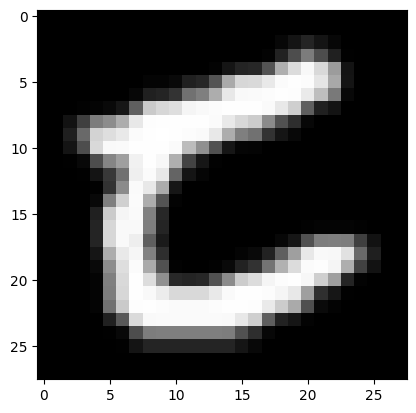

true label = y = 14

predicted label = 14



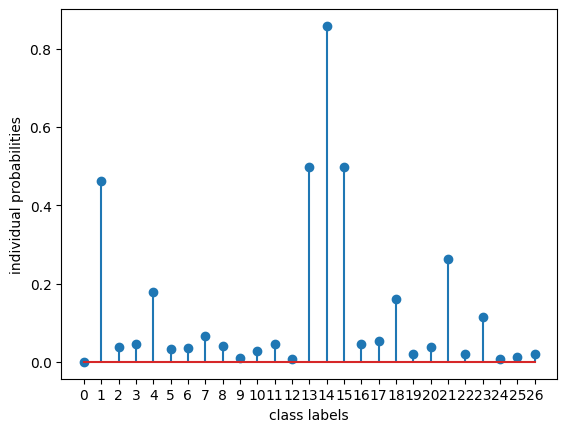

The individual probabilities do not necessarily add to one: their sum = 3.597
loss = 2.5955


True

In [11]:
idx = np.random.choice(len(test_dataset))

x = test_dataset[idx][0]
print(f'x of {x.shape} :')
plt.imshow(x[0], cmap='gray')
plt.show()

y_ = test_dataset[idx][1]
print(f'true label = y = {y_}\n')


prob = model(x[0]).detach().flatten()
#prob = F.softmax(prob, dim=-1)                      # to make individual probabilities add to one
pred = prob.argmax().item()
print(f'predicted label = {pred}\n')

plt.stem(classes, prob)
plt.ylabel('individual probabilities')
plt.xlabel('class labels')
plt.xticks(classes)
plt.show()


print(f'The individual probabilities do not necessarily add to one: their sum = {round(torch.sum(prob).item(),3)}')
print(f'loss = {round(-torch.log(F.softmax(prob, dim=-1)[y_]).item(), 4)}')

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params == num_phases